# DirPLO on CEC2017 Benchmark Functions

This notebook demonstrates how to run the DirPLO (Direction-guided Polar Lights Optimizer) algorithm on CEC2017 benchmark functions.

In [25]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from typing import Dict, List

# Clear import cache and import PLO
import sys
import importlib
importlib.invalidate_caches()

# Remove cached modules if they exist
modules_to_remove = [name for name in sys.modules.keys() if name.startswith('utils') or name == 'PLO' or name == 'optimizer']
for module in modules_to_remove:
    if module in sys.modules:
        del sys.modules[module]

# Import PLO and related modules
from PLO import DirPLO, OriginalPLO
from utils import Problem, FloatVar
import cec2017.functions as cec2017

In [26]:
# Create a wrapper class for CEC2017 functions
class CEC2017Problem(Problem):
    def __init__(self, func_num: int, n_dims: int = 30, **kwargs):
        """
        CEC2017 Problem wrapper
        
        Args:
            func_num: Function number (1-30)
            n_dims: Problem dimension (default: 30)
        """
        self.func_num = func_num
        self.cec_func = cec2017.all_functions[func_num - 1]  # CEC functions are 0-indexed
        
        # CEC2017 bounds are typically [-100, 100] for most functions
        bounds = FloatVar(lb=[-100.0] * n_dims, ub=[100.0] * n_dims, name=f"CEC2017_F{func_num}")
        
        # Set problem name and other parameters
        kwargs.setdefault('name', f'CEC2017_F{func_num}')
        kwargs.setdefault('minmax', 'min')
        kwargs.setdefault('log_to', 'console')
        kwargs.setdefault('save_population', False)
        
        super().__init__(bounds, **kwargs)
    
    def obj_func(self, x: np.ndarray) -> float:
        """
        Objective function that calls the CEC2017 function
        
        Args:
            x: Solution vector
            
        Returns:
            Function value
        """
        # CEC2017 functions expect 2D array (1, n_dims)
        x_2d = x.reshape(1, -1)
        result = self.cec_func(x_2d)
        return float(result[0]) if hasattr(result, '__len__') else float(result)

In [27]:
# Experiment configuration
EXPERIMENT_CONFIG = {
    'dimensions': [10],  # Problem dimensions to test
    'functions': [1, 3, 4, 5, 6],  # CEC2017 functions to test (subset for demo)
    'n_runs': 1,  # Number of independent runs
    'max_epochs': 1000,  # Maximum number of iterations
    'pop_size': 30,  # Population size
    'seed_base': 42  # Base seed for reproducibility
}

print("Experiment Configuration:")
for key, value in EXPERIMENT_CONFIG.items():
    print(f"  {key}: {value}")

Experiment Configuration:
  dimensions: [10]
  functions: [1, 3, 4, 5, 6]
  n_runs: 1
  max_epochs: 1000
  pop_size: 30
  seed_base: 42


In [28]:
def run_single_experiment(algorithm_class, problem, max_epochs, pop_size, seed=None):
    """
    Run a single optimization experiment
    
    Args:
        algorithm_class: The optimizer class (DirPLO or OriginalPLO)
        problem: Problem instance
        max_epochs: Maximum number of iterations
        pop_size: Population size
        seed: Random seed
        
    Returns:
        Dictionary with results
    """
    # Create optimizer instance
    optimizer = algorithm_class(epoch=max_epochs, pop_size=pop_size)
    
    # Record start time
    start_time = time.time()
    
    # Solve the problem
    best_agent = optimizer.solve(problem, seed=seed)
    
    # Record end time
    end_time = time.time()
    
    # Extract results
    results = {
        'best_fitness': best_agent.target.fitness,
        'best_solution': best_agent.solution.copy(),
        'runtime': end_time - start_time,
        'convergence_curve': optimizer.history.list_global_best_fit.copy(),
        'algorithm': algorithm_class.__name__,
        'function': problem.get_name(),
        'dimensions': problem.n_dims,
        'seed': seed
    }
    
    return results

In [29]:
import os
import shutil

logdir = './logs/'
if os.path.exists(logdir):
    shutil.rmtree(logdir)

In [30]:
import os
import shutil
from PLO import *

# Run experiments
all_results = []
logdir = './logs/'

print("Starting experiments...\n")

if os.path.exists(logdir):
    shutil.rmtree(logdir)

for dim in EXPERIMENT_CONFIG['dimensions']:
    print(f"Testing dimension: {dim}")
    
    for func_num in range(1, 31):
        print(f"  Function F{func_num}:")
        
        # Create problem
        problem = CEC2017Problem(func_num=func_num, n_dims=dim)
        
        for run in range(EXPERIMENT_CONFIG['n_runs']):
            seed = EXPERIMENT_CONFIG['seed_base'] + run
            print(f"    Run {run + 1}/{EXPERIMENT_CONFIG['n_runs']} (seed={seed})")
            
            # Test DirPLO
            print("      Running DirPLO...", end=" ")
            try:
                dirplo_result = run_single_experiment(
                    DirPLO, problem, 
                    EXPERIMENT_CONFIG['max_epochs'], 
                    EXPERIMENT_CONFIG['pop_size'], 
                    seed
                )
                all_results.append(dirplo_result)
                print(f"Best: {dirplo_result['best_fitness']:.2e}")
            except Exception as e:
                print(f"Error: {e}")
            
            # Test Original PLO for comparison
            print("      Running SimpleBSANDGPLO...", end=" ")
            try:
                plo_result = run_single_experiment(
                    NDGPLO, problem, 
                    EXPERIMENT_CONFIG['max_epochs'], 
                    EXPERIMENT_CONFIG['pop_size'], 
                    seed
                )
                all_results.append(plo_result)
                print(f"Best: {plo_result['best_fitness']:.2e}")
            except Exception as e:
                print(f"Error: {e}")

print("\nAll experiments completed!")

Starting experiments...

Testing dimension: 10
  Function F1:
    Run 1/1 (seed=42)
      Running DirPLO... Best: 2.94e+03
      Running SimpleBSANDGPLO... Best: 7.83e+03
  Function F2:
    Run 1/1 (seed=42)
      Running DirPLO... Best: 2.00e+02
      Running SimpleBSANDGPLO... Best: 2.00e+02
  Function F3:
    Run 1/1 (seed=42)
      Running DirPLO... Best: 3.01e+02
      Running SimpleBSANDGPLO... Best: 3.00e+02
  Function F4:
    Run 1/1 (seed=42)
      Running DirPLO... Best: 4.07e+02
      Running SimpleBSANDGPLO... Best: 4.01e+02
  Function F5:
    Run 1/1 (seed=42)
      Running DirPLO... Best: 5.02e+02
      Running SimpleBSANDGPLO... Best: 5.12e+02
  Function F6:
    Run 1/1 (seed=42)
      Running DirPLO... Best: 6.01e+02
      Running SimpleBSANDGPLO... Best: 6.01e+02
  Function F7:
    Run 1/1 (seed=42)
      Running DirPLO... Best: 7.13e+02
      Running SimpleBSANDGPLO... Best: 7.17e+02
  Function F8:
    Run 1/1 (seed=42)
      Running DirPLO... Best: 8.02e+02
      Run

In [31]:
# Analyze results
if all_results:
    # Convert to DataFrame for easier analysis
    results_df = pd.DataFrame([
        {
            'Algorithm': r['algorithm'],
            'Function': r['function'],
            'Dimensions': r['dimensions'],
            'Run': r['seed'] - EXPERIMENT_CONFIG['seed_base'] + 1,
            'Best_Fitness': r['best_fitness'],
            'Runtime': r['runtime']
        }
        for r in all_results
    ])
    
    print("Results Summary:")
    print(results_df.groupby(['Algorithm', 'Function', 'Dimensions']).agg({
        'Best_Fitness': ['mean', 'std', 'min'],
        'Runtime': ['mean', 'std']
    }).round(4))
else:
    print("No results to analyze.")

Results Summary:
                                 Best_Fitness                   Runtime    
                                         mean std          min     mean std
Algorithm Function    Dimensions                                           
DirPLO    CEC2017_F1  10            2940.3268 NaN    2940.3268  11.5582 NaN
          CEC2017_F10 10            1544.2240 NaN    1544.2240  10.5413 NaN
          CEC2017_F11 10            1107.1756 NaN    1107.1756  11.8638 NaN
          CEC2017_F12 10          480712.5416 NaN  480712.5416  12.2978 NaN
          CEC2017_F13 10            7099.7994 NaN    7099.7994  12.5393 NaN
          CEC2017_F14 10            1514.8552 NaN    1514.8552  12.5477 NaN
          CEC2017_F15 10            1530.0389 NaN    1530.0389  12.1350 NaN
          CEC2017_F16 10            1607.3932 NaN    1607.3932  12.6046 NaN
          CEC2017_F17 10            1731.6350 NaN    1731.6350  14.3200 NaN
          CEC2017_F18 10            2035.9956 NaN    2035.9956  12.8103

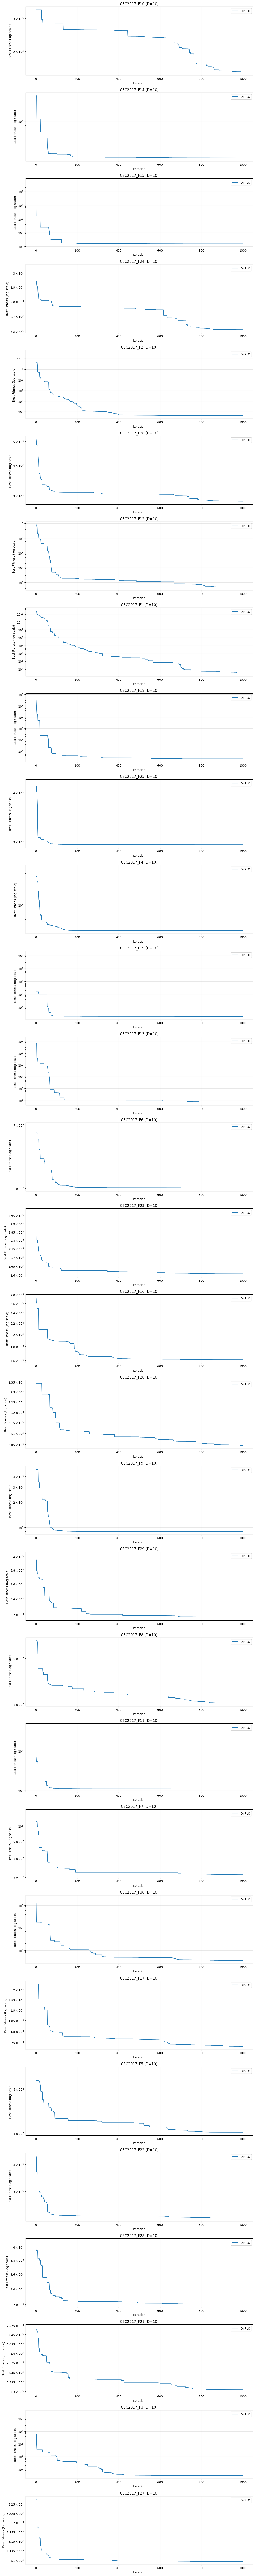

In [32]:
# Plot convergence curves
if all_results:
    # Group results by function and dimension
    unique_problems = set((r['function'], r['dimensions']) for r in all_results)
    
    fig, axes = plt.subplots(len(unique_problems), 1, figsize=(12, 4 * len(unique_problems)))
    if len(unique_problems) == 1:
        axes = [axes]
    
    for idx, (func_name, dim) in enumerate(unique_problems):
        ax = axes[idx]
        
        # Get results for this problem
        problem_results = [r for r in all_results if r['function'] == func_name and r['dimensions'] == dim]
        
        # Group by algorithm
        for algorithm in ['DirPLO', 'OriginalPLO']:
            alg_results = [r for r in problem_results if r['algorithm'] == algorithm]
            
            if alg_results:
                # Plot convergence curves for each run
                for i, result in enumerate(alg_results):
                    curve = result['convergence_curve']
                    alpha = 0.7 if len(alg_results) > 1 else 1.0
                    label = f"{algorithm}" if i == 0 else None
                    ax.semilogy(curve, alpha=alpha, label=label)
        
        ax.set_title(f"{func_name} (D={dim})")
        ax.set_xlabel("Iteration")
        ax.set_ylabel("Best Fitness (log scale)")
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No results to plot.")

In [33]:
# Detailed analysis and comparison
if all_results:
    print("\n" + "="*60)
    print("DETAILED PERFORMANCE ANALYSIS")
    print("="*60)
    
    # Compare algorithms
    for func_name in set(r['function'] for r in all_results):
        for dim in set(r['dimensions'] for r in all_results if r['function'] == func_name):
            print(f"\n{func_name} (D={dim}):")
            print("-" * 40)
            
            # Get results for this problem
            problem_results = [r for r in all_results if r['function'] == func_name and r['dimensions'] == dim]
            
            # Group by algorithm
            for algorithm in ['DirPLO', 'OriginalPLO']:
                alg_results = [r for r in problem_results if r['algorithm'] == algorithm]
                
                if alg_results:
                    fitness_values = [r['best_fitness'] for r in alg_results]
                    runtimes = [r['runtime'] for r in alg_results]
                    
                    print(f"  {algorithm}:")
                    print(f"    Best Fitness: {np.min(fitness_values):.2e}")
                    print(f"    Mean Fitness: {np.mean(fitness_values):.2e} ± {np.std(fitness_values):.2e}")
                    print(f"    Mean Runtime: {np.mean(runtimes):.2f}s ± {np.std(runtimes):.2f}s")
    
    # Statistical comparison
    print("\n" + "="*60)
    print("STATISTICAL COMPARISON (DirPLO vs OriginalPLO)")
    print("="*60)
    
    from scipy import stats
    
    for func_name in set(r['function'] for r in all_results):
        for dim in set(r['dimensions'] for r in all_results if r['function'] == func_name):
            dirplo_results = [r['best_fitness'] for r in all_results 
                             if r['function'] == func_name and r['dimensions'] == dim and r['algorithm'] == 'DirPLO']
            plo_results = [r['best_fitness'] for r in all_results 
                          if r['function'] == func_name and r['dimensions'] == dim and r['algorithm'] == 'OriginalPLO']
            
            if len(dirplo_results) > 1 and len(plo_results) > 1:
                # Wilcoxon signed-rank test
                try:
                    statistic, p_value = stats.wilcoxon(dirplo_results, plo_results)
                    significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
                    
                    improvement = (np.mean(plo_results) - np.mean(dirplo_results)) / np.mean(plo_results) * 100
                    
                    print(f"\n{func_name} (D={dim}):")
                    print(f"  p-value: {p_value:.4f} {significance}")
                    print(f"  Improvement: {improvement:+.2f}%")
                except:
                    print(f"\n{func_name} (D={dim}): Statistical test failed")
else:
    print("No results available for analysis.")


DETAILED PERFORMANCE ANALYSIS

CEC2017_F24 (D=10):
----------------------------------------
  DirPLO:
    Best Fitness: 2.61e+03
    Mean Fitness: 2.61e+03 ± 0.00e+00
    Mean Runtime: 15.99s ± 0.00s

CEC2017_F5 (D=10):
----------------------------------------
  DirPLO:
    Best Fitness: 5.02e+02
    Mean Fitness: 5.02e+02 ± 0.00e+00
    Mean Runtime: 10.26s ± 0.00s

CEC2017_F10 (D=10):
----------------------------------------
  DirPLO:
    Best Fitness: 1.54e+03
    Mean Fitness: 1.54e+03 ± 0.00e+00
    Mean Runtime: 10.54s ± 0.00s

CEC2017_F30 (D=10):
----------------------------------------
  DirPLO:
    Best Fitness: 3.47e+05
    Mean Fitness: 3.47e+05 ± 0.00e+00
    Mean Runtime: 21.97s ± 0.00s

CEC2017_F16 (D=10):
----------------------------------------
  DirPLO:
    Best Fitness: 1.61e+03
    Mean Fitness: 1.61e+03 ± 0.00e+00
    Mean Runtime: 12.60s ± 0.00s

CEC2017_F29 (D=10):
----------------------------------------
  DirPLO:
    Best Fitness: 3.16e+03
    Mean Fitness: 3.1